In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Parameter
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = 0.8

In [ ]:
# Load data
data = pd.read_csv('dataset.csv')
sentences = data['text'].str.lower().tolist()
labels = data['label'].tolist()

# Daftar stopwords
stopword = [
    "yang", "dan", "di", "ke", "dari", "untuk", "dengan", "pada", "adalah",
    "ini", "itu", "saya", "kita", "anda", "akan", "telah", "sebagai", "atau",
    "jadi", "karena", "tidak", "dalam", "lebih", "lagi", "hanya", "sudah", "juga"
]


In [4]:
# Preprocessing
processed_sentences = []
for sentence in sentences:
    for word in stopword:
        sentence = sentence.replace(f" {word} ", " ")
    processed_sentences.append(sentence.strip())

# Split data
train_size = int(len(processed_sentences) * training_portion)
train_sentences = processed_sentences[:train_size]
train_labels = labels[:train_size]
validation_sentences = processed_sentences[train_size:]
validation_labels = labels[train_size:]

In [5]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

In [6]:
# CNN Model
model = models.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.Conv1D(128, 5, activation='relu'),  # Conv1D layer with 128 filters and kernel size of 5
    layers.GlobalMaxPooling1D(),  # Global max pooling
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='softmax')  # Adjust output layer based on your number of classes
])

C:\Users\adisu\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
# Compile Model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=2,
                           verbose=1,
                           restore_best_weights=True,
                           min_delta=0.01,
                           mode='max',
                           baseline=0.94)

# Train Model
history = model.fit(train_padded, training_label_seq,
                    epochs=10,
                    validation_data=(validation_padded, validation_label_seq),
                    callbacks=[early_stop])


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1860 - loss: 1.9829 - val_accuracy: 0.7362 - val_loss: 0.8996
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8592 - loss: 0.5504 - val_accuracy: 0.9538 - val_loss: 0.2150
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9661 - loss: 0.1321 - val_accuracy: 0.9525 - val_loss: 0.1720
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9866 - loss: 0.0567 - val_accuracy: 0.9575 - val_loss: 0.1402
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


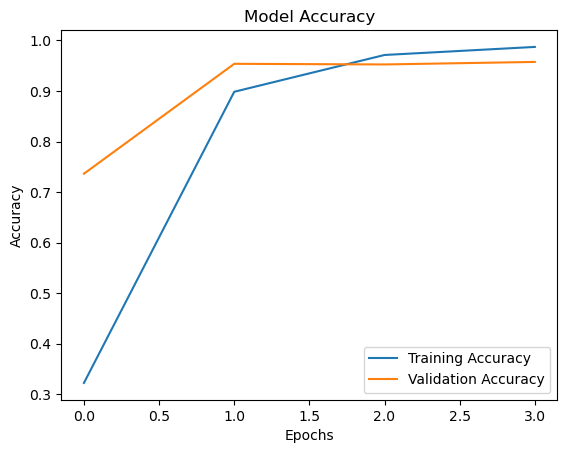

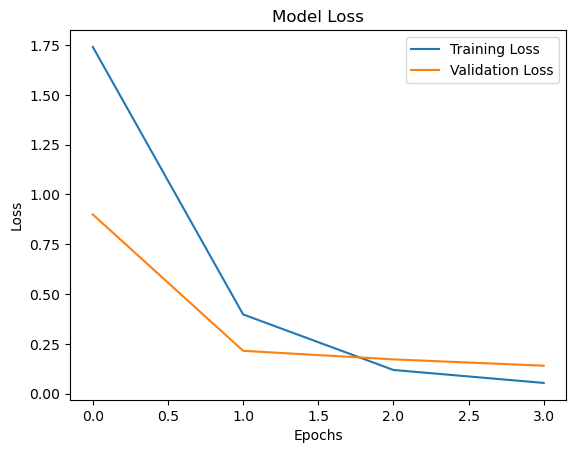

In [8]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Function to preprocess and predict new input sentences
def predict_sentence(input_sentence):
    # Preprocess the input sentence (lowercase and remove stopwords)
    input_sentence = input_sentence.lower()
    for word in stopword:
        input_sentence = input_sentence.replace(f" {word} ", " ")

    # Tokenize and pad the input sentence
    input_sequence = tokenizer.texts_to_sequences([input_sentence])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding=padding_type)

    # Predict using the trained model
    prediction = model.predict(input_padded)
    predicted_class = np.argmax(prediction, axis=-1)[0]

    # Print results
    print(f"Input Sentence: {input_sentence}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence Scores: {prediction[0]}")

    return predicted_class

# Test the model with manual input
while True:
    test_sentence = input("Enter a sentence to test (or type 'exit' to quit): ")
    if test_sentence.lower() == 'exit':
        break
    predict_sentence(test_sentence)

Enter a sentence to test (or type 'exit' to quit):  saya melihat dia selingkuh hari ini 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Input Sentence: saya melihat dia selingkuh hari 
Predicted Class: 6
Confidence Scores: [0.3554089  0.00124708 0.00107285 0.01202979 0.08393906 0.05746302
 0.40707174 0.08176746]


Enter a sentence to test (or type 'exit' to quit):  cintaku ditolak oleh dia


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input Sentence: cintaku ditolak oleh dia
Predicted Class: 7
Confidence Scores: [0.01593812 0.00742732 0.04640103 0.0026049  0.01923247 0.08455773
 0.0363831  0.7874554 ]
